# Visualizing Premier League Data (2)

##### Source for this data: https://www.bbc.com/sport/football/premier-league/table
---
We're looking at the premier league table to determine **possible** correlation between Goal Difference and Points

*Edit 1-27-26:* This data is no longer scrapable. Will construct table from scratch

## Libraries

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Constructing Premier League Table:

In [2]:
raw_matches = pd.read_csv(r'../data/E0_2526.csv')

What we'll do here is take in match-level data and then output the league table (turning 1 row per match into 1 row per team.)

Every match gives us:
- Home team
- Away team
- Full-time home goals
- Full-time away goals

What we need is (schema for our dataframe):
- Team name
- Matches played by that team
- Matches won, drawn, and lost by that team
- Goals fowarded (scored)
- Goals allowed (conceded)
- Points (sum up 3 for win, 1 for tie, and 0 for loss)
- Form (Definitely do last 5 matches)

**Make sure to add up stats for the away team as well. Every match becomes two rows.** 

Further ideas: 
- Like njsports.com, they have "strength" rankings where they see how much a team beats another team and compare it with their predictions, and that residual will create "power points", which are averaged and then compared with other teams.

In [3]:
#testing
for index, row in raw_matches.iterrows():
    print(row['Date'], row['HomeTeam'], row['AwayTeam'], row['FTHG'], row['FTAG'])

15/08/2025 Liverpool Bournemouth 4 2
16/08/2025 Aston Villa Newcastle 0 0
16/08/2025 Brighton Fulham 1 1
16/08/2025 Sunderland West Ham 3 0
16/08/2025 Tottenham Burnley 3 0
16/08/2025 Wolves Man City 0 4
17/08/2025 Chelsea Crystal Palace 0 0
17/08/2025 Nott'm Forest Brentford 3 1
17/08/2025 Man United Arsenal 0 1
18/08/2025 Leeds Everton 1 0
22/08/2025 West Ham Chelsea 1 5
23/08/2025 Man City Tottenham 0 2
23/08/2025 Bournemouth Wolves 1 0
23/08/2025 Brentford Aston Villa 1 0
23/08/2025 Burnley Sunderland 2 0
23/08/2025 Arsenal Leeds 5 0
24/08/2025 Crystal Palace Nott'm Forest 1 1
24/08/2025 Everton Brighton 2 0
24/08/2025 Fulham Man United 1 1
25/08/2025 Newcastle Liverpool 2 3
30/08/2025 Chelsea Fulham 2 0
30/08/2025 Man United Burnley 3 2
30/08/2025 Sunderland Brentford 2 1
30/08/2025 Tottenham Bournemouth 0 1
30/08/2025 Wolves Everton 2 3
30/08/2025 Leeds Newcastle 0 0
31/08/2025 Brighton Man City 2 1
31/08/2025 Nott'm Forest West Ham 0 3
31/08/2025 Liverpool Arsenal 1 0
31/08/2025

### Constructing table through defaultdict

In [4]:
#loop through matches
from collections import defaultdict

#initialize raw data storage, schema will be like this:

# "team": [matches played, W, D, L, GF, GA, GD, Points, Last 5 results (tentative)]

raw_df = defaultdict(lambda: [0, 0, 0, 0, 0, 0, 0, 0, []])

for index, row in raw_matches.iterrows():
    #identify home & away team
    home = row['HomeTeam']
    away = row['AwayTeam']

    #get # of goals for both home and away team and also the result of the match
    home_GF = row['FTHG']
    away_GF = row['FTAG']
    result = row['FTR']

    #matches played
    raw_df[home][0] += 1
    raw_df[away][0] += 1

    #GF
    raw_df[home][4] += home_GF
    raw_df[home][5] += away_GF
    raw_df[away][4] += away_GF
    raw_df[away][5] += home_GF

    # Result and points
    if result == 'H':
        #increase win column because home team won
        raw_df[home][1] += 1
        #increase loss column because away team lost
        raw_df[away][3] += 1 
        raw_df[home][7] += 3
        raw_df[home][8].append('W')
        raw_df[home][8] = raw_df[home][8][-5:]  # Keep only last 5 results
        raw_df[away][8].append('L')
        raw_df[away][8] = raw_df[away][8][-5:]  # Keep only last 5 results
    elif result == 'A':
        raw_df[away][1] += 1
        raw_df[home][3] += 1
        raw_df[away][7] += 3
        raw_df[away][8].append('W')
        raw_df[away][8] = raw_df[away][8][-5:]  # Keep only last 5 results
        raw_df[home][8].append('L')
        raw_df[home][8] = raw_df[home][8][-5:]  # Keep only last 5 results
    elif result == 'D':
        raw_df[home][2] += 1
        raw_df[away][2] += 1
        raw_df[home][7] += 1
        raw_df[away][7] += 1
        raw_df[home][8].append('D')
        raw_df[home][8] = raw_df[home][8][-5:]  # Keep only last 5 results
        raw_df[away][8].append('D')
        raw_df[away][8] = raw_df[away][8][-5:]  # Keep only last 5 results

# Goal Difference
for team in raw_df:
    raw_df[team][6] = raw_df[team][4] - raw_df[team][5]

# Build DataFrame
league_table = pd.DataFrame.from_dict(
    raw_df,
    orient='index',
    columns=['MP','W','D','L','GF','GA','GD','Pts','Last5']
)

# Sort like Premier League
league_table = league_table.sort_values(by=['Pts','GD','GF'], ascending=False)

league_table

,MP,W,D,L,GF,GA,GD,Pts,Last5
Arsenal,23,15,5,3,42,17,25,50,"[W, W, D, D, L]"
Man City,23,14,4,5,47,21,26,46,"[D, D, D, L, W]"
Aston Villa,23,14,4,5,35,25,10,46,"[L, W, D, L, W]"
Man United,23,10,8,5,41,34,7,38,"[D, D, D, W, W]"
Chelsea,23,10,7,6,39,25,14,37,"[D, D, L, W, W]"
Liverpool,23,10,6,7,35,32,3,36,"[D, D, D, D, L]"
Fulham,23,10,4,9,32,32,0,34,"[D, D, W, L, W]"
Brentford,23,10,3,10,35,32,3,33,"[D, W, W, L, L]"
Newcastle,23,9,6,8,32,29,3,33,"[W, W, W, D, L]"
Everton,23,9,6,8,25,26,-1,33,"[W, L, D, W, D]"


In [5]:
# need to scrape premier league table data for more analysis
#creating scatter plot of goal diff. vs points

plt.figure(figsize=(8,6))
prem_table_df = league_table.copy()

prem_table_df = prem_table_df.reset_index()
prem_table_df.index = prem_table_df.index + 1

prem_table_df = prem_table_df.rename(columns={'index': 'Team'})

prem_table_df

,Team,MP,W,D,L,GF,GA,GD,Pts,Last5
1,Arsenal,23,15,5,3,42,17,25,50,"[W, W, D, D, L]"
2,Man City,23,14,4,5,47,21,26,46,"[D, D, D, L, W]"
3,Aston Villa,23,14,4,5,35,25,10,46,"[L, W, D, L, W]"
4,Man United,23,10,8,5,41,34,7,38,"[D, D, D, W, W]"
5,Chelsea,23,10,7,6,39,25,14,37,"[D, D, L, W, W]"
6,Liverpool,23,10,6,7,35,32,3,36,"[D, D, D, D, L]"
7,Fulham,23,10,4,9,32,32,0,34,"[D, D, W, L, W]"
8,Brentford,23,10,3,10,35,32,3,33,"[D, W, W, L, L]"
9,Newcastle,23,9,6,8,32,29,3,33,"[W, W, W, D, L]"
10,Everton,23,9,6,8,25,26,-1,33,"[W, L, D, W, D]"


<Figure size 800x600 with 0 Axes>

## Temporal Dynamics Analysis - Team Form (In terms of W, L, and D)

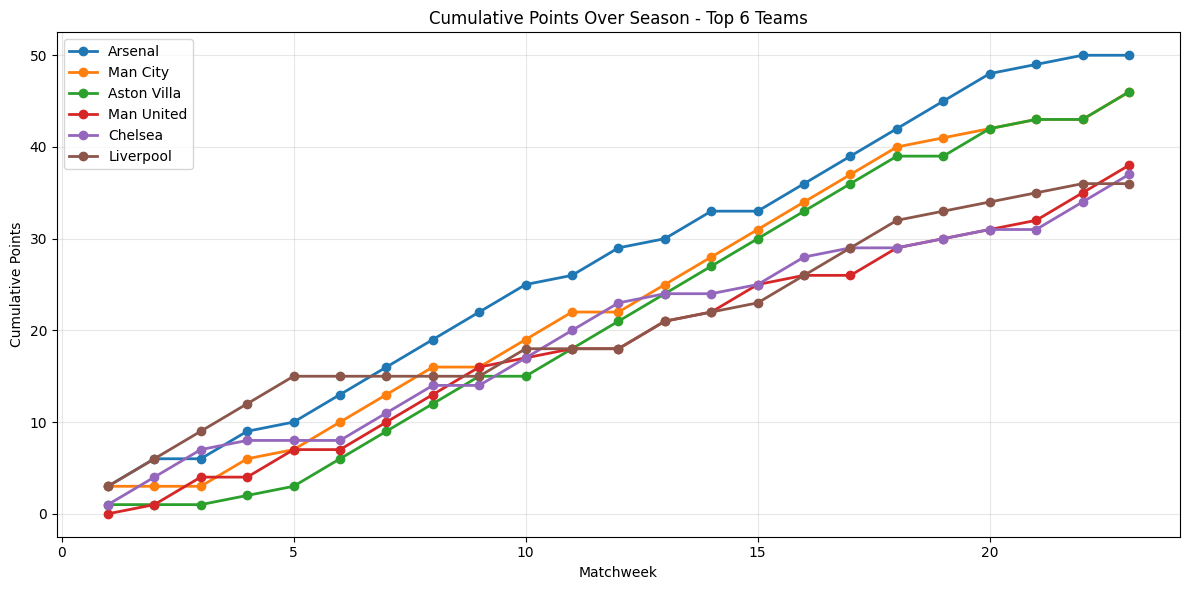

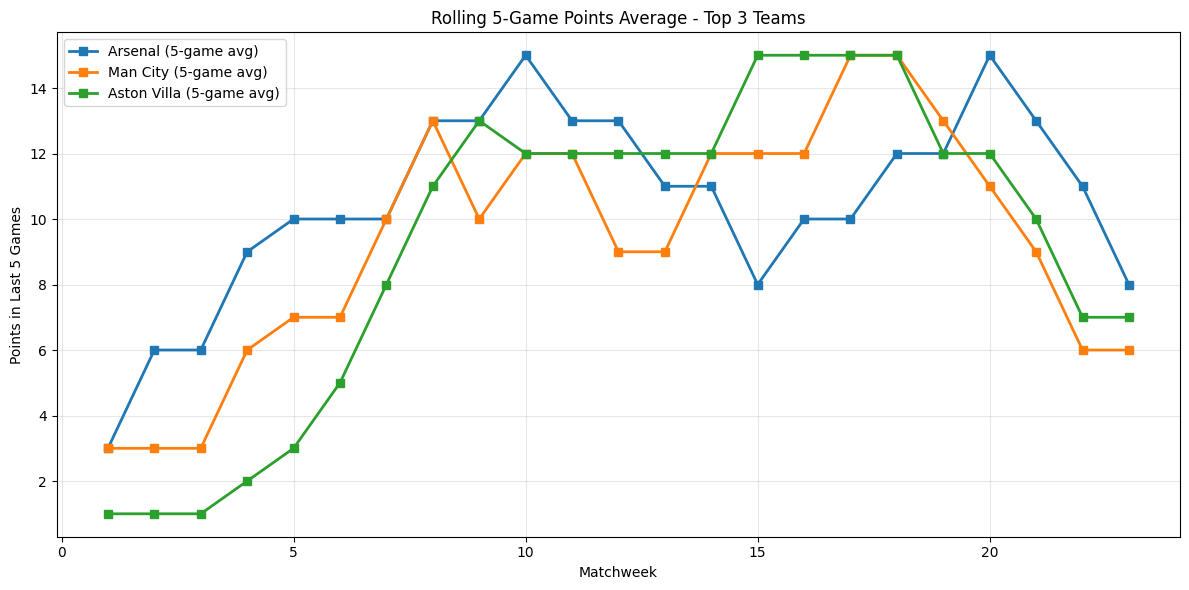

In [ ]:
import matplotlib.pyplot as plt


#taking the top 6 teams for analysis
top_teams = prem_table_df.head(6)['Team'].tolist()

#initializing storage for match stats
match_stats = {team: {'matchweek': [], 'cumulative_pts': [], 'rolling_5_pts': []} for team in top_teams}
cumulative_points = {team: 0 for team in top_teams}
recent_results = {team: [] for team in top_teams}

#looping through raw matches to calculate cumulative points and rolling 5-game average for top teams
for index, row in raw_matches.iterrows():
    matchweek = index // 10 + 1
    
    for team in top_teams:
        is_home = row['HomeTeam'] == team
        is_away = row['AwayTeam'] == team
        
        if is_home or is_away:
            if row['FTR'] == 'H' and is_home:
                pts_earned = 3
            elif row['FTR'] == 'A' and is_away:
                pts_earned = 3
            elif row['FTR'] == 'D':
                pts_earned = 1
            else:
                pts_earned = 0
            
            cumulative_points[team] += pts_earned
            recent_results[team].append(pts_earned)
            
            #recent results only keeps last 5 results
            recent_results[team] = recent_results[team][-5:]
            
            rolling_5_avg = sum(recent_results[team])
            
            match_stats[team]['matchweek'].append(matchweek)
            match_stats[team]['cumulative_pts'].append(cumulative_points[team])
            match_stats[team]['rolling_5_pts'].append(rolling_5_avg)


#plotting
plt.figure(figsize=(12, 6))
for team in top_teams:
    x = np.array(match_stats[team]['matchweek'])
    y = np.array(match_stats[team]['cumulative_pts'])
    plt.plot(x, y, marker='o', label=team, linewidth=2)

plt.xlabel('Matchweek')
plt.ylabel('Cumulative Points')
plt.title('Cumulative Points Over Season - Top 6 Teams')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#plotting rolling points
plt.figure(figsize=(12, 6))
for team in top_teams[:3]:
    x = np.array(match_stats[team]['matchweek'])
    y = np.array(match_stats[team]['rolling_5_pts'])
    plt.plot(x, y, marker='s', label=f'{team} (5-game avg)', linewidth=2)

plt.xlabel('Matchweek')
plt.ylabel('Points in Last 5 Games')
plt.title('Rolling 5-Game Points Average - Top 3 Teams')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Strength Distributions

### 1) Distribution of GD. across teams

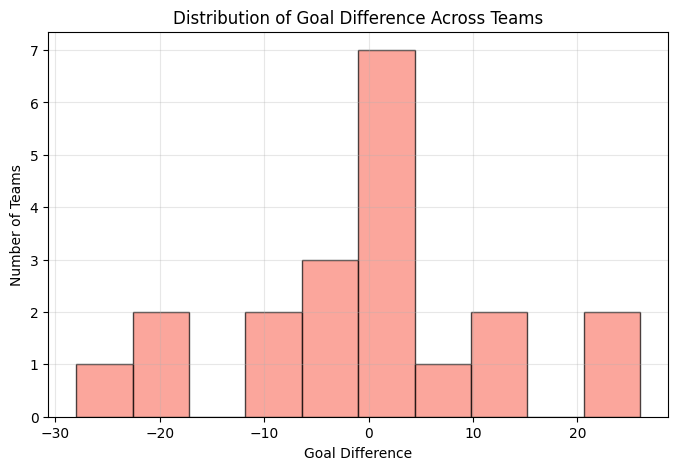

In [11]:
gd = prem_table_df['GD'].values

plt.figure(figsize=(8,5))
plt.hist(gd, bins=10, alpha=0.7, color='salmon', edgecolor='black')
plt.xlabel('Goal Difference')
plt.ylabel('Number of Teams')
plt.title('Distribution of Goal Difference Across Teams')
plt.grid(True, alpha=0.3)
plt.show()

### 2) Z-Scoring & Percentile each team (according to the mean)

In [ ]:
from scipy.stats import zscore, percentileofscore

#z-score for points and goal difference
prem_table_df['Pts_zscore'] = zscore(prem_table_df['Pts'])
prem_table_df['GD_zscore']  = zscore(prem_table_df['GD'])

#percentile rank for all teams
prem_table_df['Pts_pct'] = prem_table_df['Pts'].apply(lambda x: percentileofscore(prem_table_df['Pts'], x))
prem_table_df['GD_pct']  = prem_table_df['GD'].apply(lambda x: percentileofscore(prem_table_df['GD'], x))

#getting all of the summary columns into another table for easier visualization
summary_cols = ['Team', 'Pts', 'GD', 'Pts_zscore', 'GD_zscore', 'Pts_pct', 'GD_pct']
summary_table = prem_table_df[summary_cols].sort_values(by='Pts', ascending=False).reset_index(drop=True)

#rounding
summary_table['Pts_zscore'] = summary_table['Pts_zscore'].round(2)
summary_table['GD_zscore']  = summary_table['GD_zscore'].round(2)

summary_table['Pts_pct'] = summary_table['Pts_pct'].round(1)
summary_table['GD_pct']  = summary_table['GD_pct'].round(1)

summary_table

,Team,Pts,GD,Pts_zscore,GD_zscore,Pts_pct,GD_pct
0,Arsenal,50,25,1.89,1.93,100.0,95.0
1,Aston Villa,46,10,1.48,0.77,92.5,85.0
2,Man City,46,26,1.48,2.00,92.5,100.0
3,Man United,38,7,0.67,0.54,85.0,80.0
4,Chelsea,37,14,0.57,1.08,80.0,90.0
5,Liverpool,36,3,0.46,0.23,75.0,70.0
6,Fulham,34,0,0.26,0.00,70.0,50.0
7,Everton,33,-1,0.16,-0.08,57.5,45.0
8,Sunderland,33,-2,0.16,-0.15,57.5,40.0
9,Newcastle,33,3,0.16,0.23,57.5,70.0


We can also convert our Z-scores into qualitative variables describing strength, where:

| Category         | Z-score Range   |
|-----------------|----------------|
| **Strong**       | Z ≥ 1          |
| **Above Average**| 0 ≤ Z < 1      |
| **Average**      | -1 < Z < 0     |
| **Weak**         | Z ≤ -1         |

In [21]:
def strength_category(z):
    if z >= 1:
        return "Strong"
    elif 0 <= z < 1:
        return "Above Average"
    elif -1 < z < 0:
        return "Average"
    else:
        return "Weak"

summary_table['Strength'] = summary_table['Pts_zscore'].apply(strength_category)
#updated summary table with strength category based on points z-score
summary_table

,Team,Pts,GD,Pts_zscore,GD_zscore,Pts_pct,GD_pct,Strength
0,Arsenal,50,25,1.89,1.93,100.0,95.0,Strong
1,Aston Villa,46,10,1.48,0.77,92.5,85.0,Strong
2,Man City,46,26,1.48,2.00,92.5,100.0,Strong
3,Man United,38,7,0.67,0.54,85.0,80.0,Above Average
4,Chelsea,37,14,0.57,1.08,80.0,90.0,Above Average
5,Liverpool,36,3,0.46,0.23,75.0,70.0,Above Average
6,Fulham,34,0,0.26,0.00,70.0,50.0,Above Average
7,Everton,33,-1,0.16,-0.08,57.5,45.0,Above Average
8,Sunderland,33,-2,0.16,-0.15,57.5,40.0,Above Average
9,Newcastle,33,3,0.16,0.23,57.5,70.0,Above Average


### Export

In [24]:
# Export league table and summary table to CSV files
prem_table_df.to_csv(r'../data/league_table2526.csv')
summary_table.to_csv(r'../data/summary_table2526.csv', index=False)

print("League table exported to ../data/league_table2526.csv")
print("Summary table exported to ../data/summary_table2526.csv")

League table exported to ../data/league_table2526.csv
Summary table exported to ../data/summary_table2526.csv
